# Imports

In [1]:
import numpy as np
from scipy.stats import mannwhitneyu

from khan_helpers import Experiment
from khan_helpers.constants import (
    CORRECT_ANSWER_COLOR, 
    FIG_DIR, 
    INCORRECT_ANSWER_COLOR
)
from khan_helpers.functions import reconstruct_trace

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/opt/conda/lib/python3.9/site-packages/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Define some helper functions

In [2]:
def format_stats(stat, p, stat_name, df=None):
    stat_fmt = fr'${stat_name}$'
    if df is not None:
        stat_fmt = f'{stat_fmt}({df})'
    
    if stat // 1 == stat:
        stat_val = int(stat)
    else:
        stat_val = f'{stat:.3f}'.rstrip('.0')
    
    stat_fmt = f'{stat_fmt} = {stat_val}\n$p$'
    if p < 0.001:
        p_fmt = ' < 0.001'
    else:
        p_fmt = f' = {p:.3f}'
    
    return f'{stat_fmt}{p_fmt}'

# Estimate knowledge for held-out question

In [3]:
exp = Experiment()

In [4]:
knowledge_estimates = {}
for quiz in range(1, 4):
    correct_knowledge_estimates = []
    incorrect_knowledge_estimates = []

    for p in exp.participants:
        quiz_data = p.get_data(quiz=quiz-1)
        
        for ix, heldout_question_data in enumerate(quiz_data.itertuples()):
            if heldout_question_data.qID == 38:
                continue
            
            other_questions_data = quiz_data.drop(index=heldout_question_data.Index)
            heldout_question = exp.question_vectors[heldout_question_data.qID - 1]
            other_questions = exp.question_vectors[other_questions_data['qID'] - 1]
            accuracy = other_questions_data['accuracy']
            knowledge_estimate = reconstruct_trace(heldout_question[None, :], 
                                                   other_questions, 
                                                   accuracy).item()
            if heldout_question_data.accuracy == 1:
                correct_knowledge_estimates.append(knowledge_estimate)
            else:
                incorrect_knowledge_estimates.append(knowledge_estimate)

    knowledge_estimates[f'quiz{quiz}'] = {
        'correct': correct_knowledge_estimates, 
        'incorrect': incorrect_knowledge_estimates
    }

# Construct and display figure

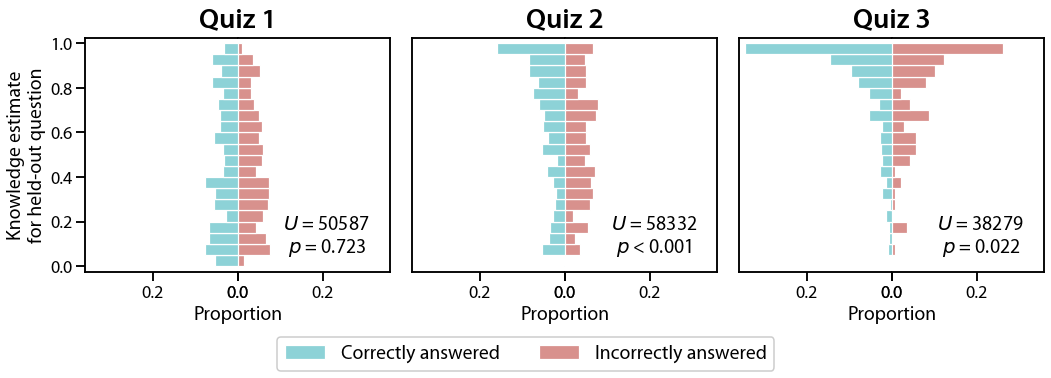

In [5]:
with sns.plotting_context('talk', font_scale=1.1):
    fig = plt.figure(figsize=(15, 5))
    main_gs = fig.add_gridspec(1, 3)

    quiz1_gs = main_gs[0].subgridspec(1, 2, wspace=0)
    quiz2_gs = main_gs[1].subgridspec(1, 2, wspace=0)
    quiz3_gs = main_gs[2].subgridspec(1, 2, wspace=0)
    
    ax1 = fig.add_subplot(quiz1_gs[0])
    ax2 = fig.add_subplot(quiz1_gs[1], sharey=ax1)
    ax3 = fig.add_subplot(quiz2_gs[0], sharey=ax1)
    ax4 = fig.add_subplot(quiz2_gs[1], sharey=ax1)
    ax5 = fig.add_subplot(quiz3_gs[0], sharey=ax1)
    ax6 = fig.add_subplot(quiz3_gs[1], sharey=ax1)
    
    axarr = np.array((ax1, ax2, ax3, ax4, ax5, ax6))
    bins = np.linspace(0, 1, 21, endpoint=True, dtype=np.float16)
    
    for quiz, (left_ax, right_ax) in enumerate(axarr.reshape(3, 2), start=1):
        quiz_estimates = knowledge_estimates[f'quiz{quiz}']
        correct_estimates = quiz_estimates['correct']
        incorrect_estimates = quiz_estimates['incorrect']
        
        U, p = mannwhitneyu(correct_estimates, incorrect_estimates)
        
        sns.histplot(y=correct_estimates, 
                     bins=bins,
                     stat='proportion',
                     color=CORRECT_ANSWER_COLOR,
                     edgecolor='white',
                     ax=left_ax, 
                     label='correct')
        sns.histplot(y=incorrect_estimates, 
                     bins=bins,
                     stat='proportion',
                     color=INCORRECT_ANSWER_COLOR,
                     edgecolor='white',
                     ax=right_ax, 
                     label='incorrect')
        
        left_ax.set_xlim(0, 0.36)
        right_ax.set_xlim(0, 0.36)
        
        left_ax.set_title(f'Quiz {quiz}', 
                          x=1,
                          y=1.02, 
                          fontsize='x-large', 
                          fontweight='semibold')
        
        left_ax.set_xlabel('Proportion', x=1, ha='center')
        right_ax.set_xlabel(None)
        
        left_ax.invert_xaxis()
        
        right_ax.annotate(format_stats(U, p, 'U'), 
                          xy=(0.21, 0.06), 
                          fontsize='medium',
                          ha='center')

        left_ax.spines['right'].set_visible(False)
        right_ax.spines['left'].set_visible(False)
        
    ax1.set_ylim(-0.025, 1.025)
    ax1.set_ylabel('Knowledge estimate\nfor held-out question')
    
    for ax in axarr[1:]:
        ax.tick_params(left=False, labelleft=False)
    
    fig.legend((ax1.containers[0], ax2.containers[0]), 
               ('Correctly answered', 'Incorrectly answered'), 
               loc='lower center', 
               ncol=2, 
               fontsize='medium',
               framealpha=1, 
               bbox_to_anchor=(0.5, -0.1))
        
    plt.tight_layout()
#     plt.savefig(FIG_DIR.joinpath('held-out-question-analysis.pdf'), bbox_inches='tight')
    plt.show()

# Expanded version of analysis & figure with cross-lecture predictions

In [6]:
knowledge_estimates = {
    'heldout_question': {},
    'lec1_given_lec2': {},
    'lec2_given_lec1': {}
}

for quiz in range(1, 4):
    heldout_correct = []
    heldout_incorrect = []
    lec1_given_lec2_correct = []
    lec1_given_lec2_incorrect = []
    lec2_given_lec1_correct = []
    lec2_given_lec1_incorrect = []
    
    for p in exp.participants:
        # data for all questions given participant saw on given quiz
        quiz_data = p.get_data(quiz=quiz-1)
        # subset of quiz questions about each lecture 
        lec1_question_data = quiz_data.query('lecture == 1')
        lec2_question_data = quiz_data.query('lecture == 2')
        # accuracy for quiz questions about each lecture
        lec1_question_accuracy = lec1_question_data['accuracy']
        lec2_question_accuracy = lec2_question_data['accuracy']
        # topic vectors for quiz questions about each lecture
        lec1_question_vecs = exp.question_vectors[lec1_question_data['qID'] - 1]
        lec2_question_vecs = exp.question_vectors[lec2_question_data['qID'] - 1]
        
        # iteratively hold out one question, estimate knowledge based on
        # performance on all other questions
        for ix, heldout_question_data in enumerate(quiz_data.itertuples()):
            if heldout_question_data.qID == 38:
                continue
            
            heldin_questions_data = quiz_data.drop(index=heldout_question_data.Index)
            heldout_question = exp.question_vectors[heldout_question_data.qID - 1]
            heldin_questions = exp.question_vectors[heldin_questions_data['qID'] - 1]
            accuracy = heldin_questions_data['accuracy']
            knowledge_estimate = reconstruct_trace(heldout_question[None, :], 
                                                   heldin_questions, 
                                                   accuracy).item()
            if heldout_question_data.accuracy == 1:
                heldout_correct.append(knowledge_estimate)
            else:
                heldout_incorrect.append(knowledge_estimate)
                
        # estimate knowledge for each lecture 1 question given 
        # performance on all lecture 2 questions, and vice versa
        for q_ix in range(5):
            lec1_target_question = lec1_question_vecs[q_ix]
            lec2_target_question = lec2_question_vecs[q_ix]
            
            lec1_question_knowledge_estimate = reconstruct_trace(
                lec1_target_question[None, :], 
                lec2_question_vecs, 
                lec2_question_accuracy
            ).item()
            lec2_question_knowledge_estimate = reconstruct_trace(
                lec2_target_question[None, :], 
                lec1_question_vecs, 
                lec1_question_accuracy
            ).item()
            
            if lec1_question_accuracy.iloc[q_ix] == 1:
                lec1_given_lec2_correct.append(lec1_question_knowledge_estimate)
            else:
                lec1_given_lec2_incorrect.append(lec1_question_knowledge_estimate)
            
            
            if lec2_question_accuracy.iloc[q_ix] == 1:
                lec2_given_lec1_correct.append(lec2_question_knowledge_estimate)
            else:
                lec2_given_lec1_incorrect.append(lec2_question_knowledge_estimate)
                
    quiz_str = f'quiz{quiz}'
    knowledge_estimates['heldout_question'][quiz_str] = {
        'correct': heldout_correct, 
        'incorrect': heldout_incorrect
    }
    
    knowledge_estimates['lec1_given_lec2'][quiz_str] = {
        'correct': lec1_given_lec2_correct,
        'incorrect': lec1_given_lec2_incorrect
    }
    knowledge_estimates['lec2_given_lec1'][quiz_str] = {
        'correct': lec2_given_lec1_correct,
        'incorrect': lec2_given_lec1_incorrect
    }

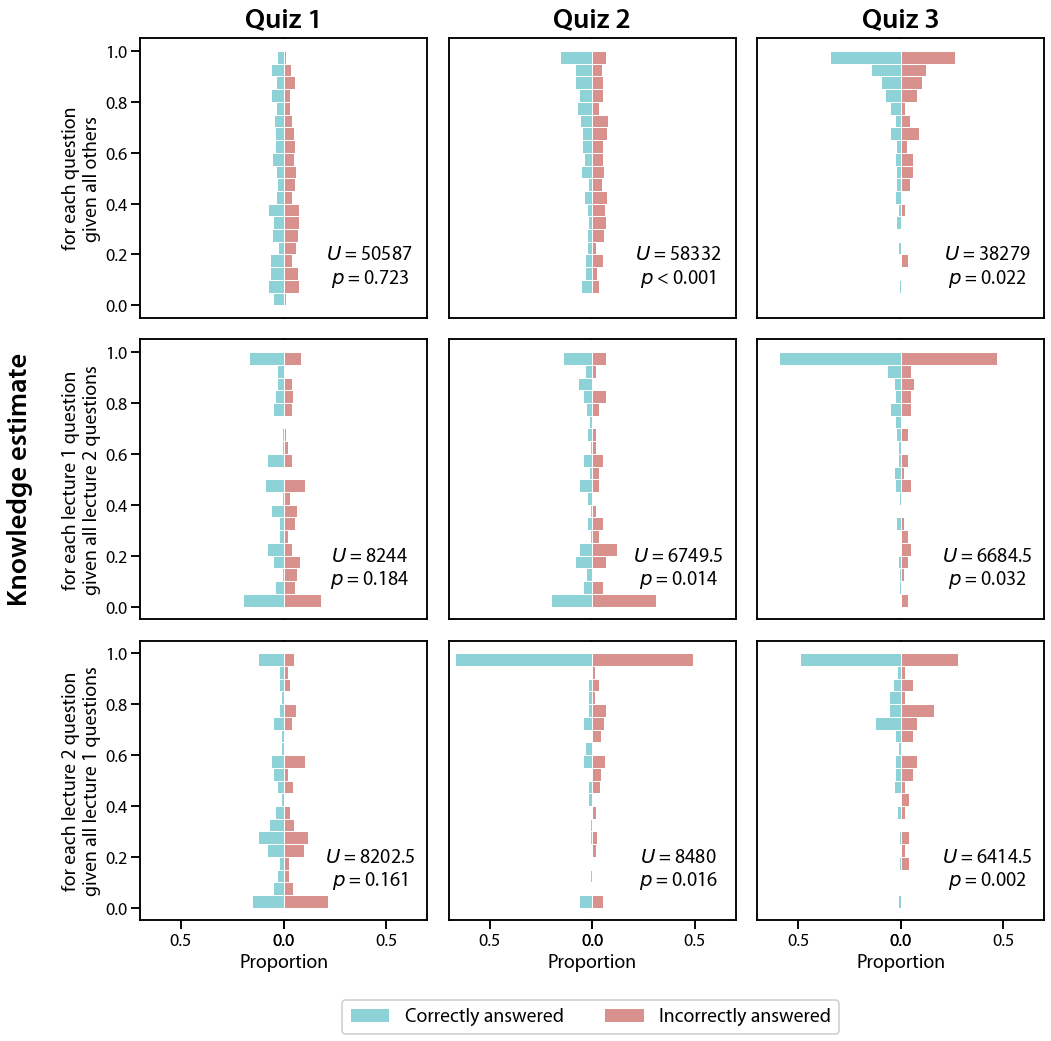

In [7]:
with sns.plotting_context('talk', font_scale=1.1):
    fig = plt.figure(figsize=(15, 14), tight_layout={'h_pad': 0})
    main_gs = fig.add_gridspec(3, 3)

    # row 1: single held-out question
    quiz1_heldout_gs = main_gs[0].subgridspec(1, 2, wspace=0)
    quiz2_heldout_gs = main_gs[1].subgridspec(1, 2, wspace=0)
    quiz3_heldout_gs = main_gs[2].subgridspec(1, 2, wspace=0)
    
    # row 2: lecture 1 questions given lecture 2 questions
    quiz1_1_2_gs = main_gs[3].subgridspec(1, 2, wspace=0)
    quiz2_1_2_gs = main_gs[4].subgridspec(1, 2, wspace=0)
    quiz3_1_2_gs = main_gs[5].subgridspec(1, 2, wspace=0)

    # row 3: lecture 2 questions given lecture 1 questions
    quiz1_2_1_gs = main_gs[6].subgridspec(1, 2, wspace=0)
    quiz2_2_1_gs = main_gs[7].subgridspec(1, 2, wspace=0)
    quiz3_2_1_gs = main_gs[8].subgridspec(1, 2, wspace=0)
    
    # top row panels paired sub-axes
    ax1 = fig.add_subplot(quiz1_heldout_gs[0])
    ax2 = fig.add_subplot(quiz1_heldout_gs[1], sharey=ax1)
    ax3 = fig.add_subplot(quiz2_heldout_gs[0], sharex=ax1, sharey=ax1)
    ax4 = fig.add_subplot(quiz2_heldout_gs[1], sharex=ax2, sharey=ax1)
    ax5 = fig.add_subplot(quiz3_heldout_gs[0], sharex=ax1, sharey=ax1)
    ax6 = fig.add_subplot(quiz3_heldout_gs[1], sharex=ax2, sharey=ax1)
    
    # middle row panels paired sub-axes
    ax7 = fig.add_subplot(quiz1_1_2_gs[0], sharex=ax1, sharey=ax1)
    ax8 = fig.add_subplot(quiz1_1_2_gs[1], sharex=ax2, sharey=ax1)
    ax9 = fig.add_subplot(quiz2_1_2_gs[0], sharex=ax1, sharey=ax1)
    ax10 = fig.add_subplot(quiz2_1_2_gs[1], sharex=ax2, sharey=ax1)
    ax11 = fig.add_subplot(quiz3_1_2_gs[0], sharex=ax1, sharey=ax1)
    ax12 = fig.add_subplot(quiz3_1_2_gs[1], sharex=ax2, sharey=ax1)
    
    # bottom row panels paired sub-axes
    ax13 = fig.add_subplot(quiz1_2_1_gs[0], sharex=ax1, sharey=ax1)
    ax14 = fig.add_subplot(quiz1_2_1_gs[1], sharex=ax2, sharey=ax1)
    ax15 = fig.add_subplot(quiz2_2_1_gs[0], sharex=ax1, sharey=ax1)
    ax16 = fig.add_subplot(quiz2_2_1_gs[1], sharex=ax2, sharey=ax1)
    ax17 = fig.add_subplot(quiz3_2_1_gs[0], sharex=ax1, sharey=ax1)
    ax18 = fig.add_subplot(quiz3_2_1_gs[1], sharex=ax2, sharey=ax1)
    
    axarr_top = np.array((ax1, ax2, ax3, ax4, ax5, ax6))
    axarr_middle = np.array((ax7, ax8, ax9, ax10, ax11, ax12))
    axarr_bottom = np.array((ax13, ax14, ax15, ax16, ax17, ax18))
    
    axarr_rows = (axarr_top, axarr_middle, axarr_bottom)
    knowledge_estimate_rows = ('heldout_question', 
                                'lec1_given_lec2', 
                                'lec2_given_lec1')
    
    bins = np.linspace(0, 1, 21, endpoint=True, dtype=np.float16)
    
    for i, axarr in enumerate(axarr_rows):
        row_knowledge_estimates = knowledge_estimates[knowledge_estimate_rows[i]]
        
        for quiz, (left_ax, right_ax) in enumerate(axarr.reshape(3, 2), start=1):
            quiz_estimates = row_knowledge_estimates[f'quiz{quiz}']
            correct_estimates = quiz_estimates['correct']
            incorrect_estimates = quiz_estimates['incorrect']

            U, p = mannwhitneyu(correct_estimates, incorrect_estimates)

            sns.histplot(y=correct_estimates, 
                         bins=bins,
                         stat='proportion',
                         color=CORRECT_ANSWER_COLOR,
                         edgecolor='white',
                         ax=left_ax, 
                         label='correct')
            sns.histplot(y=incorrect_estimates, 
                         bins=bins,
                         stat='proportion',
                         color=INCORRECT_ANSWER_COLOR,
                         edgecolor='white',
                         ax=right_ax, 
                         label='incorrect')
            
            left_ax.set_xlabel(None)
            right_ax.set_xlabel(None)
            left_ax.spines['right'].set_visible(False)
            right_ax.spines['left'].set_visible(False)
            
            right_ax.annotate(format_stats(U, p, 'U'), 
                              xy=(0.6, 0.125),
                              xycoords='axes fraction',
                              fontsize='medium',
                              ha='center')
            
        for ax in axarr[1:]:
            ax.tick_params(left=False, labelleft=False)
    
    ax1.set_xlim(0, 0.7)
    ax2.set_xlim(0, 0.7)
    ax1.invert_xaxis()
    ax1.set_ylim(-0.05, 1.05)
    
    for i in range(6):
        axarr_top[i].tick_params(bottom=False, labelbottom=False)
        axarr_middle[i].tick_params(bottom=False, labelbottom=False)
        if not i % 2:
            axarr_top[i].set_title(f'Quiz {i // 2 + 1}', 
                                   x=1,
                                   y=1.02, 
                                   fontsize='x-large', 
                                   fontweight='semibold')
            axarr_bottom[i].set_xlabel('Proportion', x=1, ha='center')    
            
    ax7.annotate('Knowledge estimate', 
                 xy=(-0.75, 0.5), 
                 xycoords=ax7.yaxis.label,
                 fontsize='x-large',
                 fontweight='semibold',
                 rotation=90,
                 ha='right',
                 va='center')
    
    ax1.set_ylabel('for each question\ngiven all others')
    ax7.set_ylabel('for each lecture 1 question\ngiven all lecture 2 questions')
    ax13.set_ylabel('for each lecture 2 question\ngiven all lecture 1 questions')
    
    fig.legend((ax1.containers[0], ax2.containers[0]), 
               ('Correctly answered', 'Incorrectly answered'), 
               loc='lower center', 
               ncol=2, 
               fontsize='medium',
               framealpha=1, 
               bbox_to_anchor=(0.56, -0.05))
        
#     plt.savefig(FIG_DIR.joinpath('predict-knowledge-questions-expanded.pdf'), 
#                 bbox_inches='tight', 
#                 dpi=300)
    plt.show()